## nn 作って plasiticc で活かしたい
やること
 * 基本的な mlp 作成　& 性能調査
 * cnn 使った band 間の情報抽出

In [445]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pandas as pd
from scipy.special import erfinv

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
import lightgbm

from logging import getLogger
from tqdm import tqdm
import argparse
import datetime
import pickle
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')

from tools.my_logging import logInit
from tools.feature_tools import feature_engineering
from tools.objective_function import weighted_multi_logloss, lgb_multi_weighted_logloss, wloss_objective, wloss_metric, softmax, calc_team_score
from tools.model_io import save_models, load_models
from tools.fold_resampling import get_fold_resampling_dict

In [2]:
NTHREAD = 30
%load_ext autoreload
%autoreload 2

In [13]:
# torch の tutorial 回してみた

In [209]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


horse  ship   cat horse


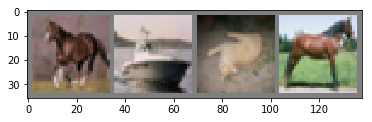

Process Process-62:
Process Process-61:
Traceback (most recent call last):
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/naoya.taguchi

In [210]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [211]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [212]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [215]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            print(loss.grad)
            print(labels)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.388
None
tensor([6, 7, 4, 9])


Process Process-67:
Process Process-68:
Traceback (most recent call last):
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])


KeyboardInterrupt: 

  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/cifar.py", line 121, in __getitem__
    img = self.transform(img)
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py", line 49, in __call__
    img = t(img)
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py", line 76, in __call__
    return F.to_tensor(pic)
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/functional.py", line 83, in to_tensor
    return img.float().div(255)
KeyboardInterrupt
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/process.

GroundTruth:    cat  ship  ship plane


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f29a295f2b0>>
Traceback (most recent call last):
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/naoya.taguchi/anaconda3/lib/python3.6/mult

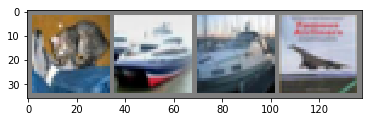

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## nn の作成開始
まずは　mlp から。
 * ネットワーク構造、batchnorm の有無、drop out の値を　configurable に
 * cnn との連携を意識
 * 

In [569]:
class plasticcNet(nn.Module):
    def __init__(self, mlp_shapes, band_cnn_idxes=None):
        super(plasticcNet, self).__init__()
        self.activation = torch.nn.ELU()
        self.band_cnn_idxes = band_cnn_idxes
        # band 軽特徴量間の幾何的構造に基づく関係性を捉える cnn 
        self.band_conv_nets = []
        if band_cnn_idxes:
            for band_cnn_idx in band_cnn_idxes:
                None
            None
        self.dense_nets = nn.ModuleList()
        #self.dense_nets = []
        self.batch_norms = nn.ModuleList()
        #self.batch_norms = []
        self.dropouts = nn.ModuleList()
        #self.dropouts = []
        # mlp を組む
        for i, shape in enumerate(mlp_shapes):
            self.dense_nets.append(nn.Linear(shape[0], shape[1]))
            #self.batch_norms.append(nn.LayerNorm(shape[1]))
            self.batch_norms.append(nn.BatchNorm1d(shape[1]))
            if i == 0:
                p = 0.00
            elif i == len(mlp_shapes) - 1:
                p = 0.0
            else:
                p = 0.0
            self.dropouts.append(nn.Dropout(p=p))
            
    def forward(self, x):
        if len(self.band_conv_nets) > 0:
            for band_conv_net in self.band_conv_nets:
                None
        for i, nets in enumerate(list(zip(self.dense_nets, self.batch_norms, self.dropouts))):
            dense_net, batch_norm, dropout = nets
            if i < len(self.dense_nets) - 1:
                #x = torch.relu(dense_net(x))
                x = self.activation(dense_net(x))
                #ac = torch.nn.LeakyReLU()
                #ac = torch.nn.ELU()
                #ac = torch.nn.PReLU()
                #x = ac(x)
                #x = torch.selu(dense_net(x))
                #x = torch.tanh(dense_net(x))
                x = batch_norm(x)
                x = dropout(x)
            else:
                x =  dense_net(x)
                #x = batch_norm(x)
                #x = dropout(x)
                #x =  torch.softmax(dense_net(x), dim=1)
        return x

In [5]:
pnn = plasticcNet(mlp_shapes=((100, 20), (20, 1)))
pnn

plasticcNet()

In [6]:
input = torch.randn(20, 100)
res = pnn(input)
res

tensor([[-0.1152],
        [ 0.0955],
        [ 0.0000],
        [ 0.1930],
        [-0.2114],
        [-0.1143],
        [-0.1207],
        [ 0.0140],
        [-0.1164],
        [ 0.0820],
        [ 0.0000],
        [-0.0000],
        [ 0.0000],
        [-0.0961],
        [ 0.0558],
        [-0.0563],
        [ 0.0571],
        [-0.2034],
        [-0.0281],
        [ 0.1225]], grad_fn=<DropoutBackward>)

#### とりあえずネットワークはできたので loss を定義して学習させてみる

In [446]:
# feature を作る
logger = getLogger(__name__)
logInit(logger, log_dir='../log/', log_filename='notebook.log')

training_set_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set.csv')
training_set_metadata_df = pd.read_csv('/home/naoya.taguchi/.kaggle/competitions/PLAsTiCC-2018/training_set_metadata.csv')
train_df = feature_engineering(
        training_set_df,
        training_set_metadata_df,
        nthread=NTHREAD,
        logger=logger)

2018-11-23 16:09:53,682 __main__             680 [INFO] [feature_engineering] getting split dfs ... 
2018-11-23 16:09:53,682 __main__             680 [INFO] [feature_engineering] getting split dfs ... 
INFO:__main__:getting split dfs ...
2018-11-23 16:09:53,685 __main__             38 [INFO] [split_dfs] calculating uniq object_id num 
2018-11-23 16:09:53,685 __main__             38 [INFO] [split_dfs] calculating uniq object_id num 
INFO:__main__:calculating uniq object_id num
2018-11-23 16:09:53,695 __main__             40 [INFO] [split_dfs] getting groups 
2018-11-23 16:09:53,695 __main__             40 [INFO] [split_dfs] getting groups 
INFO:__main__:getting groups
2018-11-23 16:09:53,697 __main__             42 [INFO] [split_dfs] splitting df 
2018-11-23 16:09:53,697 __main__             42 [INFO] [split_dfs] splitting df 
INFO:__main__:splitting df

100%|██████████| 30/30 [00:01<00:00, 15.08it/s]
2018-11-23 16:09:55,694 __main__             687 [INFO] [feature_engineering] adding c

In [20]:
# 欠損率計算関数
def get_null_stat(df):
    whole_num = df.shape[0]
    res_list = []
    for col in df.columns:
        res_list.append([col, df[df[col].isnull()].shape[0]/whole_num])
    return pd.DataFrame(res_list).rename(columns={0: 'column', 1: 'null_rat'})

In [34]:
# 欠損値が多い... とりあえず　mean で埋めるか...
null_df = get_null_stat(train_df).sort_values('null_rat', ascending=False)
null_df[null_df.null_rat != 0]

,column,null_rat


In [447]:
# 欠損値埋め
#from tqdm import tqdm_notebook as tqdm
#for col in tqdm(train_df.columns):
#    target_series = train_df[col]
#    target_series[target_series.isnull()] = target_series.mean()
train_df = train_df.replace(np.inf, np.nan)
train_df = train_df.replace(-np.inf, np.nan)
train_df = train_df.fillna(train_df.mean())#.drop(null_df[null_df.null_rat != 0]['column'], axis=1)

In [247]:
from torchvision import transforms

class plasticcDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
#        self.y = torch.from_numpy(y.astype(np.float32))
        self.y = torch.LongTensor(y.astype(np.float32))
        #self.y = y
#        self.transform = transforms.Compose([transforms.ToTensor()])
 
    def __len__(self):
        return self.x.shape[0]
 
    def __getitem__(self, idx):
        # tolist がないとエラー吐く
        return self.x[idx, :], self.y[idx]
        #return self.transform(self.x[idx, :]), self.transform(self.y[idx])
        #return self.x[idx, :].tolist(), self.y[idx].tolist()


    
label_num = 14
FOLD_NUM = 5
le = LabelEncoder()
le.fit(train_df['target'].values)
x_train = train_df.drop('target', axis=1).values
y_train = le.transform(train_df.target)   

dataset = plasticcDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=250, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    x, y = sample_batched
    #print(x)
    break

In [52]:
print(x_train.dtype)
x_train.astype(np.float32)

object


array([[0.0000000e+00, 4.1263962e+01, 3.3065610e+09, ..., 8.6252874e-01,
        1.3747127e-01, 1.0000000e+00],
       [2.5520000e-01, 4.5406300e+01, 1.2057575e+10, ..., 2.9571021e-01,
        7.0428979e-01, 0.0000000e+00],
       [1.5699999e-02, 4.0256100e+01, 1.1251748e+09, ..., 8.6330366e-01,
        1.3669635e-01, 0.0000000e+00],
       ...,
       [0.0000000e+00, 4.1263962e+01, 3.3065610e+09, ..., 6.6294086e-01,
        3.3705917e-01, 1.0000000e+00],
       [0.0000000e+00, 4.1263962e+01, 3.3065610e+09, ..., 8.9639026e-01,
        1.0360976e-01, 1.0000000e+00],
       [0.0000000e+00, 4.1263962e+01, 3.3065610e+09, ..., 9.3905771e-01,
        6.0942307e-02, 1.0000000e+00]], dtype=float32)

In [180]:
class GaussRankScaler():

    def __init__(self):
        self.epsilon = 0.001
        self.lower = -1 + self.epsilon
        self.upper = 1 - self.epsilon
        self.range = self.upper - self.lower

    def fit_transform(self, X):

        i = np.argsort(X, axis=0)
        j = np.argsort(i, axis=0)

        assert (j.min() == 0).all()
        assert (j.max() == len(j) - 1).all()

        j_range = len(j) - 1
        self.divider = j_range / self.range

        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv(transformed)

        return transformed
    
def continuousNormalization(target_df, scaler):
    for column in tqdm(target_df.columns.values):
        # minmax normalization for continuous data
        if target_df[column].dtype != 'object' and column != 'target':
            if target_df[column].max() > 0:
                target_df[column] = \
                    scaler.fit_transform(target_df[column])
    return target_df    
    
scaler = GaussRankScaler()    
train_df = continuousNormalization(train_df, scaler)

100%|██████████| 252/252 [00:00<00:00, 349.16it/s]


In [ ]:
#train_df = 

In [573]:
# objective
# y_h に nan が起こりうる -> classsize が　0 になりうるのでどうにかせねば...
# 
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
def wloss_metric(preds, train_data):
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    #weight_tensor = torch.tensor(list(class_weight.values()), requires_grad=True).type(torch.FloatTensor)
    y_t = torch.tensor(train_data, requires_grad=True).type(torch.LongTensor)
    y_h = torch.zeros(y_t.shape[0], len(classes), requires_grad=True).scatter(1, y_t.reshape(-1, 1), 1)
    print(y_t.shape)
    y_h[y_h == 0] = 1
    y_h /= y_h.sum(dim=0, keepdim=True)
    y_p = torch.tensor(preds, requires_grad=True).type(torch.FloatTensor)
    if len(y_p.shape) == 1:
        y_p = y_p.reshape(len(classes), -1).transpose(0, 1)
    ln_p = torch.log_softmax(y_p, dim=1)
    wll = torch.sum(y_h * ln_p, dim=0)
    loss = -torch.dot(weight_tensor, wll) / torch.sum(weight_tensor)
    return loss

def mywloss(y_pred_raw, y_true):  
    weight_tensor = torch.tensor(np.array(list(class_weight.values())).astype(np.float), requires_grad=True).type(torch.FloatTensor)
    y_onehot = torch.FloatTensor(y_true.shape[0], len(classes))
    y_onehot.zero_()
    y_onehot.scatter_(1, y_true.reshape(-1, 1), 1)
    
#    y_pred=torch.clamp(y_pred,1e-15,1-1e-15)
    y_pred_log=torch.log_softmax(y_pred_raw, dim=1)
    class_num = torch.sum(y_onehot, dim=0)
    class_num[class_num == 0] = 1
#    print(y_pred.shape)
#    print(y_onehot.shape)
#    print(torch.mean(y_onehot*torch.log(y_pred), dim=0).shape)
#    print(y_pred)
#    print(torch.log(y_pred))
#    print(weight_tensor)
#    print((class_num.numpy() == 0).any())
    loss=-(torch.mean(torch.sum(torch.sum(y_onehot*y_pred_log, dim=0)*weight_tensor/class_num) / torch.sum(weight_tensor)))
#            torch.mean(y_onehot*torch.log(y_pred), dim=0)/weight_tensor
    return loss

def get_l2_loss(model, weight=0.1):
    l2_weight = torch.tensor(weight)
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return l2_weight * l2_reg

In [615]:
feats_df = pd.read_csv('../importances/Booster_weight-multi-logloss-0.579991_2018-11-20-13-16-50_importance.csv')
feats_df

,feature,importance_1,importance_2,importance_3,importance_4,importance_5,importance_mean,importance_std,importance_cov
0,band-4_flux_diff,3.877149,110.378603,3.337464,9.850000,1.376004,25.763844,47.406868,1.840054
1,flux_ratio_sq_kurtosis,4.466670,3.508977,3.271847,1.852178,35.689840,9.757902,14.526536,1.488695
2,passband_flux_means_var,10.430280,9.877646,136.335002,9.573529,21.001303,37.443552,55.489190,1.481942
3,flux_diff,36.171543,4.911519,0.857851,3.081147,4.871393,9.978691,14.735943,1.476741
4,flux_std,108.792653,12.284080,13.534921,15.695708,2.997915,30.661055,43.945350,1.433263
5,band-0_detected_mean,1.069664,24.448623,2.925277,4.484955,2.932387,7.172181,9.733311,1.357092
6,band_flux_diff_diff,10.967242,33.592161,16.056421,132.825686,7.726280,40.233558,52.714288,1.310207
7,band-4_normed_amp,0.807821,0.019941,4.888293,0.093319,2.547364,1.671348,2.066345,1.236335
8,band-3_std_upper_flux_count,10.514201,4.516352,22.024038,1.465285,0.717647,7.847505,8.814045,1.123165
9,band-3_flux_diff,1.876173,1.459195,12.709589,2.702602,2.530644,4.255641,4.752335,1.116714


In [619]:
label_num = 14
FOLD_NUM = 5
le = LabelEncoder()
le.fit(train_df['target'].values)

# remove features
#pd.read_csv

#x_train = train_df[[]].drop('target', axis=1).values
x_train = train_df.drop(list(feats_df.feature.tolist())[:170], axis=1).drop('target', axis=1).values
y_train = le.transform(train_df.target)

ss = StandardScaler()
scaler = GaussRankScaler()    
#x_train = ss.fit_transform(x_train)
x_train = scaler.fit_transform(x_train)

skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=71)
folds = skf.split(x_train, y_train)
max_layer_size = 1024
#max_layer_size = 2048
#max_layer_size = 4096
#max_layer_size = 512
#max_layer_size = 128
#max_layer_size = 64
#max_layer_size = 256


best_models = []
best_scores = []
for trn_idx, val_idx in tqdm(list(folds)):
    x_trn, x_val = x_train[trn_idx], x_train[val_idx]
    y_trn, y_val = y_train[trn_idx], y_train[val_idx]
    mlp_shapes = (
        (x_trn.shape[1], max_layer_size), 
#        (max_layer_size, max_layer_size//4), 
#        (max_layer_size//4, max_layer_size//16), 
        (max_layer_size, max_layer_size//2), 
        (max_layer_size//2, max_layer_size//4),
        (max_layer_size//4, label_num))
#        (max_layer_size//16, max_layer_size//32),
#        (max_layer_size//32, label_num))
#        (max_layer_size, max_layer_size//32), 
#        (max_layer_size//32, label_num))
#        (max_layer_size, max_layer_size//2), 
#        (max_layer_size//2, label_num))
#        (max_layer_size//4, max_layer_size//8), 
#        (max_layer_size//8, label_num))
#        (max_layer_size//4, max_layer_size//8), 
#        (max_layer_size//8, label_num))
#        (max_layer_size//8, max_layer_size//16),
#        (max_layer_size//16, label_num))

    pnn = plasticcNet(mlp_shapes=mlp_shapes)
    optimizer = optim.SGD(pnn.parameters(), lr=0.3, )
    #optimizer = optim.ASGD(pnn.parameters(), lr=0.3,  )
    #optimizer = optim.Adam(pnn.parameters(), lr=0.01)
    #optimizer = optim.RMSprop(pnn.parameters(), lr=0.01)   
        
    dataset = plasticcDataset(x_trn, y_trn)
    dataloader = DataLoader(dataset, batch_size=50, shuffle=True, num_workers=0)

    epochs = 1000
    losses = []
    best_loss = 100000000
    best_count = 0
    best_model = None   
    
    for epoch in range(epochs):
        for i_batch, sample_batched in enumerate(dataloader):
            optimizer.zero_grad()
            x_trn_batch, y_trn_batch = sample_batched
            _res = pnn(x_trn_batch)
            #loss = criterion(_res, y_trn_batch)
            loss = mywloss(_res, y_trn_batch)
            #loss += get_l2_loss(pnn)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().numpy())
            #break
        val_res = pnn(torch.Tensor(x_val))
        val_score = mywloss(val_res, torch.LongTensor(y_val)).detach().numpy()
        if epoch % 1 == 0:
            if best_loss > val_score:
                best_loss = val_score
                best_count = 0
                best_model = pnn
            else:
                best_count += 1
            print(f'epoch : {epoch}', f'train_loss : {np.mean(losses):.5f}', f'val_loss : {val_score:.5f}')
            losses = []
            if best_count >= 5:
                print(f'best loss is {best_loss}')
                best_models.append(best_model)
                best_val_res = pnn(torch.Tensor(x_val))
                best_val_score = mywloss(best_val_res, torch.LongTensor(y_val)).detach().numpy()
                best_scores.append(best_loss)
                break
        # break
#    break


  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 0 train_loss : 0.89810 val_loss : 0.98218
epoch : 1 train_loss : 0.64145 val_loss : 1.00868
epoch : 2 train_loss : 0.59204 val_loss : 0.75442
epoch : 3 train_loss : 0.55109 val_loss : 0.89404
epoch : 4 train_loss : 0.51872 val_loss : 0.69196
epoch : 5 train_loss : 0.49274 val_loss : 0.69753
epoch : 6 train_loss : 0.46527 val_loss : 0.72533


epoch : 7 train_loss : 0.45909 val_loss : 0.66471
epoch : 8 train_loss : 0.44272 val_loss : 0.70301
epoch : 9 train_loss : 0.40647 val_loss : 0.87094
epoch : 10 train_loss : 0.41511 val_loss : 0.70822
epoch : 11 train_loss : 0.41364 val_loss : 0.70921
epoch : 12 train_loss : 0.39742 val_loss : 0.65918
epoch : 13 train_loss : 0.37302 val_loss : 0.71926
epoch : 14 train_loss : 0.37081 val_loss : 0.68081
epoch : 15 train_loss : 0.35368 val_loss : 0.74590
epoch : 16 train_loss : 0.35344 val_loss : 0.72723


 20%|██        | 1/5 [00:20<01:23, 20.97s/it]

epoch : 17 train_loss : 0.34377 val_loss : 0.66840
best loss is 0.6591775417327881
epoch : 0 train_loss : 0.89500 val_loss : 0.93411
epoch : 1 train_loss : 0.66770 val_loss : 0.66969
epoch : 2 train_loss : 0.60136 val_loss : 0.68741
epoch : 3 train_loss : 0.53542 val_loss : 0.65454
epoch : 4 train_loss : 0.50072 val_loss : 0.66033
epoch : 5 train_loss : 0.50958 val_loss : 0.60244
epoch : 6 train_loss : 0.46729 val_loss : 0.62915
epoch : 7 train_loss : 0.47485 val_loss : 0.61905
epoch : 8 train_loss : 0.44024 val_loss : 0.60604
epoch : 9 train_loss : 0.43635 val_loss : 0.55742
epoch : 10 train_loss : 0.42069 val_loss : 0.62321
epoch : 11 train_loss : 0.43233 val_loss : 0.86700
epoch : 12 train_loss : 0.40271 val_loss : 0.58627
epoch : 13 train_loss : 0.38839 val_loss : 0.60169


 40%|████      | 2/5 [00:39<00:58, 19.58s/it]

epoch : 14 train_loss : 0.37493 val_loss : 0.57820
best loss is 0.557422935962677
epoch : 0 train_loss : 0.85562 val_loss : 0.96406
epoch : 1 train_loss : 0.66287 val_loss : 0.79310
epoch : 2 train_loss : 0.57696 val_loss : 0.79293
epoch : 3 train_loss : 0.54382 val_loss : 0.65984
epoch : 4 train_loss : 0.53063 val_loss : 0.70173
epoch : 5 train_loss : 0.48098 val_loss : 0.78938
epoch : 6 train_loss : 0.47295 val_loss : 0.71553
epoch : 7 train_loss : 0.47611 val_loss : 0.63609
epoch : 8 train_loss : 0.43150 val_loss : 0.67333
epoch : 9 train_loss : 0.42373 val_loss : 0.68208
epoch : 10 train_loss : 0.41132 val_loss : 0.69656
epoch : 11 train_loss : 0.39395 val_loss : 0.70224


 60%|██████    | 3/5 [00:54<00:36, 18.10s/it]

epoch : 12 train_loss : 0.37414 val_loss : 0.75120
best loss is 0.6360897421836853
epoch : 0 train_loss : 0.88682 val_loss : 0.88442
epoch : 1 train_loss : 0.66016 val_loss : 0.94769
epoch : 2 train_loss : 0.56941 val_loss : 0.75752
epoch : 3 train_loss : 0.53643 val_loss : 0.68476
epoch : 4 train_loss : 0.51103 val_loss : 0.78328
epoch : 5 train_loss : 0.49472 val_loss : 0.66924
epoch : 6 train_loss : 0.47353 val_loss : 0.72918
epoch : 7 train_loss : 0.45673 val_loss : 0.66322
epoch : 8 train_loss : 0.43341 val_loss : 0.65665
epoch : 9 train_loss : 0.43955 val_loss : 0.74422
epoch : 10 train_loss : 0.40797 val_loss : 0.69635
epoch : 11 train_loss : 0.39599 val_loss : 0.71004
epoch : 12 train_loss : 0.37907 val_loss : 0.68441


 80%|████████  | 4/5 [01:10<00:17, 17.67s/it]

epoch : 13 train_loss : 0.36269 val_loss : 0.71234
best loss is 0.6566498279571533
epoch : 0 train_loss : 0.86572 val_loss : 0.96332
epoch : 1 train_loss : 0.64800 val_loss : 0.94876
epoch : 2 train_loss : 0.57658 val_loss : 0.77922
epoch : 3 train_loss : 0.53851 val_loss : 0.85975
epoch : 4 train_loss : 0.49887 val_loss : 0.80263
epoch : 5 train_loss : 0.48082 val_loss : 0.81954
epoch : 6 train_loss : 0.45561 val_loss : 0.75541
epoch : 7 train_loss : 0.46263 val_loss : 0.75825
epoch : 8 train_loss : 0.44775 val_loss : 0.81905
epoch : 9 train_loss : 0.43497 val_loss : 0.79821
epoch : 10 train_loss : 0.41057 val_loss : 0.86613


100%|██████████| 5/5 [01:24<00:00, 16.95s/it]

epoch : 11 train_loss : 0.41286 val_loss : 0.78050
best loss is 0.75540691614151


In [620]:
best_models

[plasticcNet(
   (activation): ELU(alpha=1.0)
   (dense_nets): ModuleList(
     (0): Linear(in_features=81, out_features=1024, bias=True)
     (1): Linear(in_features=1024, out_features=512, bias=True)
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): Linear(in_features=256, out_features=14, bias=True)
   )
   (batch_norms): ModuleList(
     (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (dropouts): ModuleList(
     (0): Dropout(p=0.0)
     (1): Dropout(p=0.0)
     (2): Dropout(p=0.0)
     (3): Dropout(p=0.0)
   )
 ), plasticcNet(
   (activation): ELU(alpha=1.0)
   (dense_nets): ModuleList(
     (0): Linear(in_features=81, out_features=1024, bias=Tr

In [ ]:
pnn = plasticcNet(mlp_shapes=())

In [291]:
pred = torch.Tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
target = torch.LongTensor([0])
mywloss(pred, target)

tensor(2.4671, grad_fn=<NegBackward>)

In [303]:
def wloss_metric(preds, train_data):
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    #np.clip(preds, 1e-15,1-1e-15)
    weight_tensor = torch.tensor(list(class_weight.values()),
                             requires_grad=False).type(torch.FloatTensor)
    y_t = torch.tensor(train_data, requires_grad=False).type(torch.LongTensor)
    y_h = torch.zeros(
        y_t.shape[0], len(classes), requires_grad=False).scatter(1, y_t.reshape(-1, 1), 1)
    y_h[y_h == 0] = 1
    y_h /= y_h.sum(dim=0, keepdim=True)
    y_p = torch.tensor(preds, requires_grad=False).type(torch.FloatTensor)
    if len(y_p.shape) == 1:
        y_p = y_p.reshape(len(classes), -1).transpose(0, 1)
    ln_p = torch.log_softmax(y_p, dim=1)
    wll = torch.sum(y_h * ln_p, dim=0)
    loss = -torch.dot(weight_tensor, wll) / torch.sum(weight_tensor)
    return 'wloss', loss * 1., False

In [298]:
#pred = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
#target = np.array([0])
wloss_metric(pred, target)

('wloss', 2.62982439994812, False)